<a href="https://colab.research.google.com/github/flora0110/spotify_segment_headine/blob/main/textsplit_history_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install word2vec

In [ ]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [ ]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

links = {'history': 'https://raw.githubusercontent.com/flora0110/spotify_segment_headine/main/podcast_data/history_comma.txt',  # a tale of two cities
         'siddartha': 'http://www.gutenberg.org/cache/epub/2500/pg2500.txt'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

In [ ]:
corpus_path
with open('./text8','r',encoding='utf-8') as file:
    for line in file.readlines():
        print(len(line))

100000000
100000000


## Train wordvectors

In [ ]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)
  #word2vec.Word2Vec(corpus_path, wrdvec_path, cbow=1, iter_=5, hs=1, threads=8, sample='1e-5', window=15, size=200, binary=1)

In [ ]:
model.save(wrdvec_path)

In [ ]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)
# del model
print(wrdvecs.shape)

(71290, 200)
(71290, 200)


## get sentence tokenizer

In [ ]:
!pip install textsplit

     |████████████████████████████████| 154 kB 11.5 MB/s 


In [ ]:
from textsplit.tools import SimpleSentenceTokenizer
#from nltk.tokenize import sent_tokenize
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [ ]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

penalty 46.23
489 sentences, 18 segments, avg 27.17 sentences per segment
optimal score 10058.35, greedy score 10044.88
[10058.347308625058, 10044.880926299576]
(10058.347308625058, 10044.880926299576)
ratio of scores 1.0013


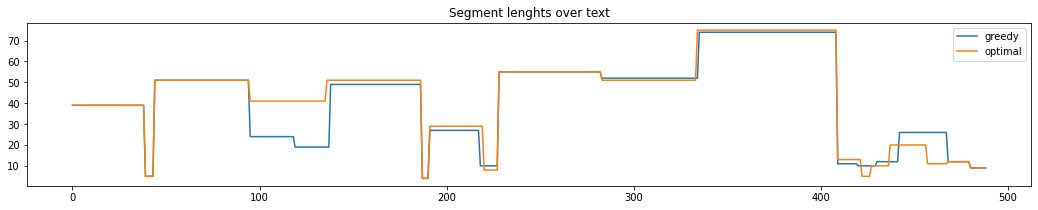

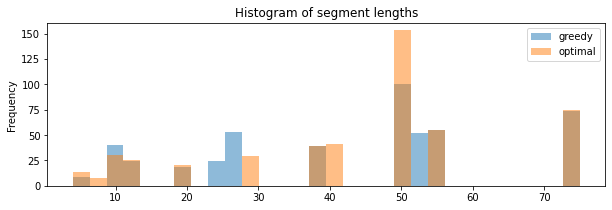

In [ ]:
# link = links['siddartha']
#import nltk
#nltk.download('punkt')
link = links['history']
segment_len = 30  # segment target length in sentences
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

#sentenced_text =sent_tokenize(text)
#for i in range(5):
#  print(sentenced_text)
sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [ ]:
for seg in [optimal_segmentation, greedy_segmentation]:
  print(seg)
print(penalty)
print(sentence_vectors)
for i in range(5):
  print(len(sentence_vectors[i]))

Segmentation(total=10058.34787235258, splits=[39, 44, 95, 136, 187, 191, 220, 228, 283, 334, 409, 422, 427, 437, 457, 468, 480], gains=[53.4636058464007, 60.907959082720254, 76.8109666208718, 60.598197566830095, 58.84646024591791, 59.4172560913662, 83.57574099525232, 56.56969339313582, 74.94362699155636, 74.15537805211352, 56.40330196762079, 63.23961966704417, 58.54534822681393, 57.66689854184892, 49.97017866360534, 50.84163944918555, 65.88619603076938], min_gain=None, optimal=True)
Segmentation(total=None, splits=[39, 44, 95, 119, 138, 187, 191, 218, 228, 283, 335, 409, 420, 430, 442, 468, 480], gains=[53.4636058464007, 60.907959082720254, 68.3080245864453, 47.38705025202023, 55.66146017234723, 58.66356900921801, 59.564109608987906, 80.77122109191691, 53.23960030302419, 73.5808213681994, 73.45968916071934, 49.74925919071529, 56.81401361790307, 60.086922195488114, 56.35096433373451, 62.86492504253147, 65.88619603076938], min_gain=46.22677860258, optimal=None)
46.22677860258
[[-3.210032

## Evaluation

If you look into the written file `book_path`.seg, the snippet line is often at the boundary of a paragraph.  The word embeddings computed above are neither very good nor adapted to the text. Every unknown word has a zero vector. Choosing some more or less random vector for unknown words might improve the accuracy given those unknown terms appear repeatedly within a section.

In [ ]:
print(text)
print(optimal_segmentation)
#for i in range(5)
#print
for i in range(21):
  print(segmented_text[i])


Hi friends. Happy Wednesday or Thursday if you're watching over on YouTube. Hey, how are you doing? I hope you're having a wonderful day so far. My name is Bailey serían and this is the dark History Podcast. Whew, I need a theme song for dark history. Don't, I'm anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that. I never learned in school. If you're new here. Hi, welcome. Come. Take a seat by me. Don't be shy if you're And learning about people and events that your history books didn't cover in school. The maybe should have then you'll fit in right in here with us. Okay. Look today's story. It's uncomfortable. Okay, it's heartbreaking. It's just, it's set. It's awful. It's sad. There's, those are all the words. I can think of it, just doesn't make any sense. But with all of that being said, there's really like no sugarcoating this. This is what happened. And it's when more honest and when we're transparent that we can lea

IndexError: ignored

Hi friends. Happy Wednesday or Thursday if you're watching over on YouTube. Hey, how are you doing? I hope you're having a wonderful day so far. My name is Bailey serían and this is the dark History Podcast. Whew, I need a theme song for dark history. Don't, I'm anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that. I never learned in school. If you're new here. Hi, welcome. Come. Take a seat by me. Don't be shy if you're And learning about people and events that your history books didn't cover in school. The maybe should have then you'll fit in right in here with us. Okay. Look today's story. It's uncomfortable. Okay, it's heartbreaking. It's just, it's set. It's awful. It's sad. There's, those are all the words. I can think of it, just doesn't make any sense. But with all of that being said, there's really like no sugarcoating this. This is what happened. And it's when more honest and when we're transparent that we can lea

IndexError: ignored